# Osher solution to a scalar Riemann problem

Implementation of the general solution to the scalar Riemann problem that is valid also for non-convex fluxes.

$$
Q(\xi) = \begin{cases} 
    \text{argmin}_{q_l \leq q \leq q_r} [f(q) - \xi q]& \text{if} ~q_l\leq q_r,\\
    \text{argmax}_{q_r \leq q \leq q_l} [f(q) - \xi q]& \text{if} ~q_r\leq q_l.\\
\end{cases}
$$

From: S.J. Osher, *Riemann Solvers, the Entropy Condition, and Difference Approximations*, SIAM J. Numer. Anal. 21(1984), pp. 217-235.  [doi:10.1137/0721016](http://dx.doi.org/10.1137/0721016)

See also Section 16.1.2. of [FVMHP](http://depts.washington.edu/clawpack/book.html).



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function

### Select an animation style:

In [3]:
import animation_tools  # local version, rather than from Clawpack

#animation_style = 'ipywidgets'
animation_style = 'JSAnimation'

In [4]:
def osher_solution(f, q_left, q_right, xi_left=None, xi_right=None):
    """
    Compute the Riemann solution to a scalar conservation law.
    
    Compute the similarity solution Q(x/t) and also the 
    (possibly multi-valued) solution determined by tracing 
    characteristics.
    
    Input:
      f = flux function (possibly nonconvex)
      q_left, q_right = Riemann data
      xi_left, xi_right = optional left and right limits for xi = x/t
               in similarity solution.
               If not specified, chosen based on the characteristic speeds.
    
    Returns:
      xi = array of values between xi_left and xi_right
      q  = array of corresponding q(xi) values (xi = x/t)
      q_char = array of values of q between q_left and q_right
      xi_char = xi value for each q_char for use in plotting the
              (possibly multi-valued) solution where each q value
              propagates at speed f'(q).
    """
    
    q_min = min(q_left, q_right)
    q_max = max(q_left, q_right)
    qv = linspace(q_min, q_max, 1000)
    
    # define the function qtilde as in (16.7)
    if q_left <= q_right:
        def qtilde(xi):
            Q = empty(xi.shape, dtype=float)
            for j,xij in enumerate(xi):
                i = argmin(f(qv) - xij*qv)
                Q[j] = qv[i]
            return Q
    else:
        def qtilde(xi):
            Q = empty(xi.shape, dtype=float)
            for j,xij in enumerate(xi):
                i = argmax(f(qv) - xij*qv)
                Q[j] = qv[i]
            return Q
        
    # The rest is just for plotting purposes:
    fv = f(qv)
    dfdq = diff(fv) / (qv[1] - qv[0])
    dfdq_min = min(dfdq)
    dfdq_max = max(dfdq)
    #print("Mininum characteristic velocity: %g" % dfdq_min)
    #print("Maximum characteristic velocity: %g" % dfdq_max)
    dfdq_range = dfdq_max - dfdq_min

    
    if xi_left is None: 
        xi_left = min(0,dfdq_min) - 0.1*dfdq_range
    if xi_right is None: 
        xi_right = max(0,dfdq_max) + 0.1*dfdq_range
        
    q_char = hstack((q_min, 0.5*(qv[:-1] + qv[1:]), q_max))
    
    if q_left <= q_right:
        xi_min = xi_left
        xi_max = xi_right
    else:
        xi_min = xi_right
        xi_max = xi_left
   
    xi_char = hstack((xi_min, dfdq, xi_max))
    
    xi = linspace(xi_left, xi_right, 1000)
    q = qtilde(xi)
    
    return xi, q, q_char, xi_char

    

## Traffic flow

First try a convex flux, such as $f(q) = q(1-q)$ from traffic flow (with $u_{max}=1$ in the notation of Chapter 11):

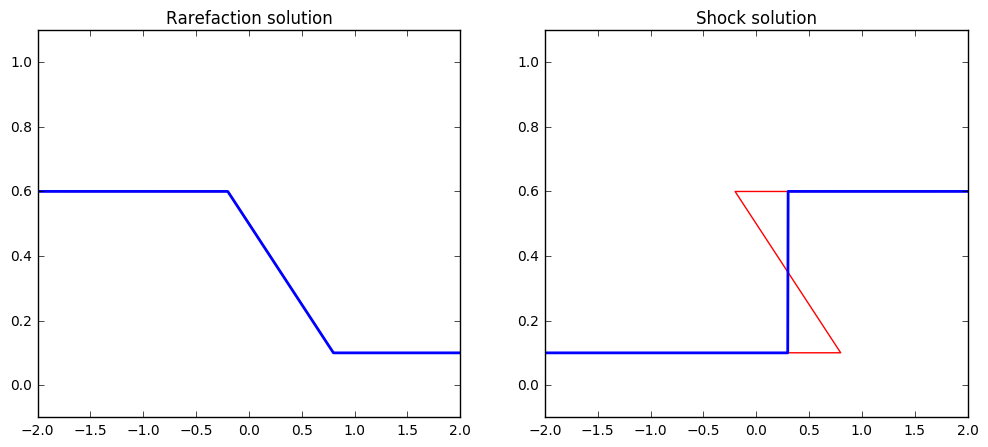

In [5]:
f = lambda q: q*(1-q)

figure(figsize=(12,5))
subplot(121)

q_left = 0.6
q_right = 0.1

xi, qxi, q_char, xi_char = osher_solution(f, q_left, q_right, -2, 2)
plot(xi_char, q_char,'r')
plot(xi, qxi, 'b', linewidth=2)
ylim(-0.1,1.1)
title('Rarefaction solution')

subplot(122)

q_left = 0.1
q_right = 0.6

xi, qxi, q_char, xi_char = osher_solution(f, q_left, q_right, -2, 2)
plot(xi_char, q_char,'r')
plot(xi, qxi, 'b', linewidth=2)
ylim(-0.1,1.1)
title('Shock solution')

## Buckley-Leverett Equation

The Buckley-Leverett equation for two-phase flow is described in Section 16.1.1.  It has the non-convext flux function

$$ 
f(q) = \frac{q^2}{q^2 + a(1-q)^2}
$$
where $a$ is some constant.

In [6]:
a = 0.5
f_buckley_leverett = lambda q: q**2 / (q**2 + a*(1-q)**2)

In [7]:
q_left = 1.
q_right = 0.

### Plot the flux and its derivative

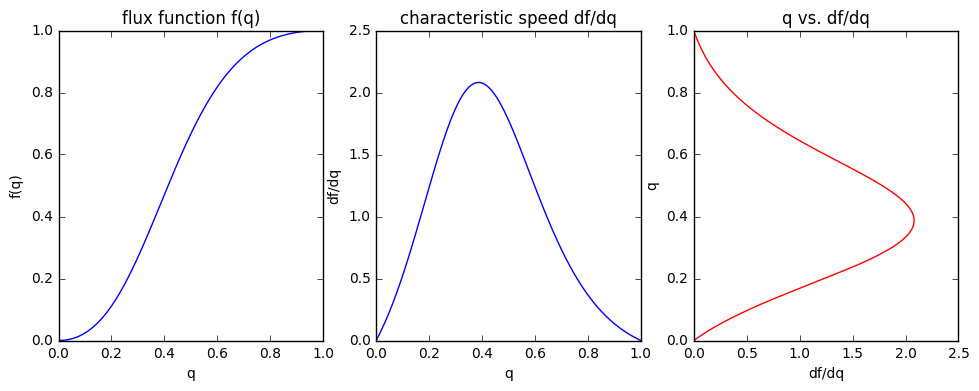

In [8]:
qvals = linspace(q_right, q_left, 200)
fvals = f_buckley_leverett(qvals)
dfdq = diff(fvals) / (qvals[1]-qvals[0])  # approximate df/dq
qmid = 0.5*(qvals[:-1] + qvals[1:])   # midpoints for plotting dfdq

figure(figsize=(10,4))
subplot(131)
plot(qvals,fvals)
xlabel('q')
ylabel('f(q)')
title('flux function f(q)')

subplot(132)
plot(qmid, dfdq)
xlabel('q')
ylabel('df/dq')
title('characteristic speed df/dq')

subplot(133)
plot(dfdq, qmid, 'r')
xlabel('df/dq')
ylabel('q')
title('q vs. df/dq')

subplots_adjust(left=0.)

Note that the third plot above shows $q$ on the vertical axis and $df/dq$ on the horizontal axis (it's the middle figure turned sideways).  You can think of this as showing the characteristic velocity for each point on a jump discontinuity from $q=0$ to $q=1$, and hence a triple valued solution of the Riemann problem at $t=1$ when each $q$ value has propagated this far.  

Below we show this together with the correct solution to the Riemann problem, with a shock wave inserted (as computed using the Osher solution defined above).  Note that for this non-convex flux function the Riemann solution consists partly of a rarefaction wave together with a shock wave.

(-0.1, 1.1)

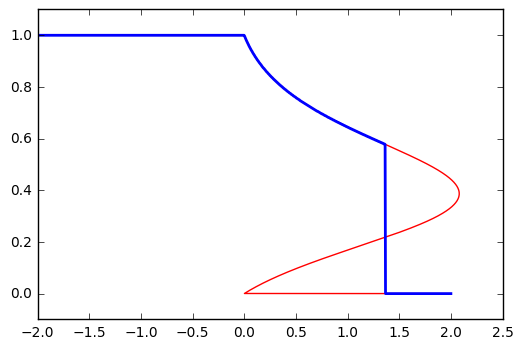

In [9]:
xi, qxi, q_char, xi_char = osher_solution(f_buckley_leverett, q_left, q_right, -2, 2)

plot(xi_char, q_char,'r')
plot(xi, qxi, 'b', linewidth=2)
ylim(-0.1,1.1)

### Create an animation:


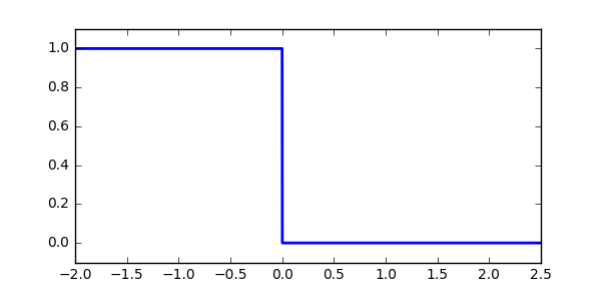
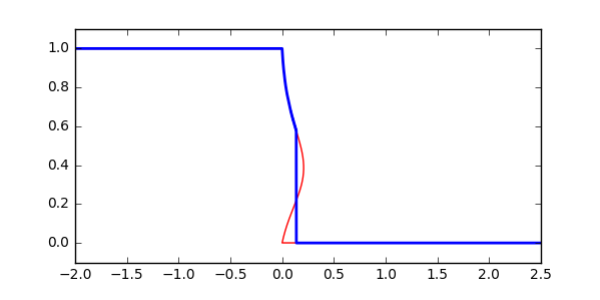
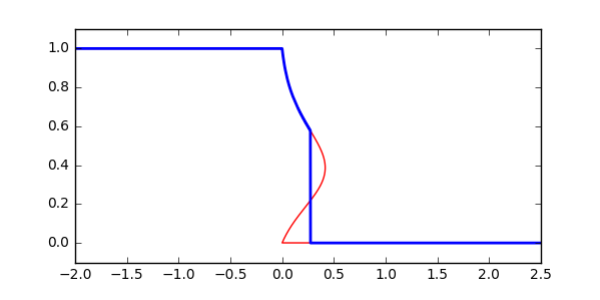
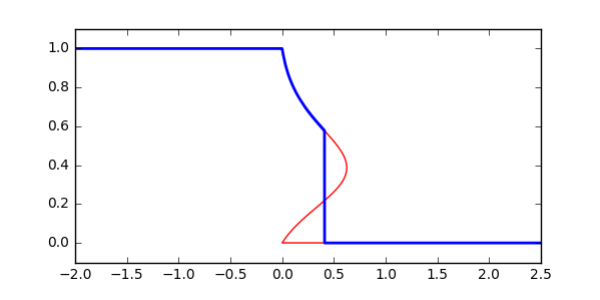
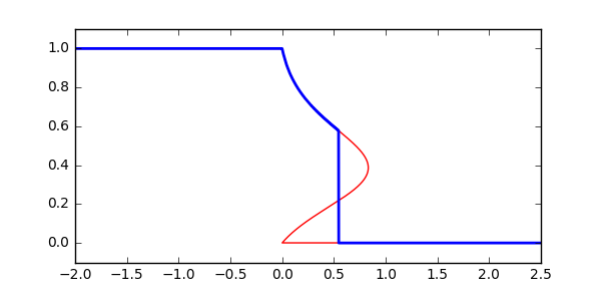
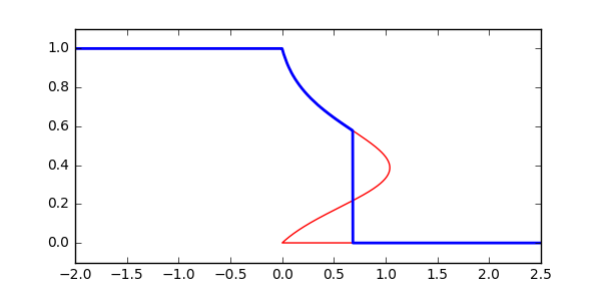
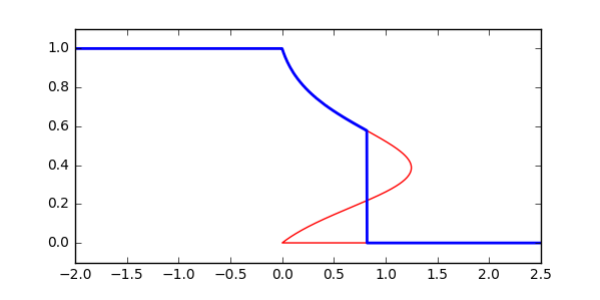
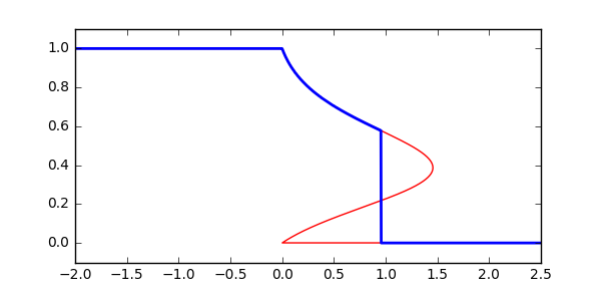
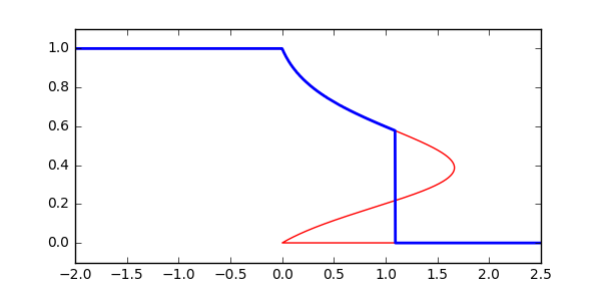
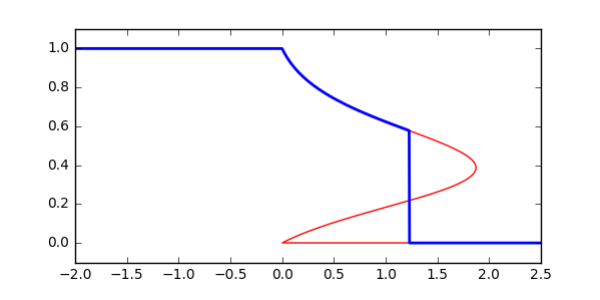
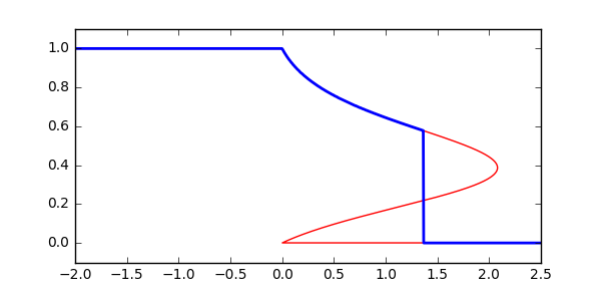

In [10]:
figs = []

# adjust first and last elements in xi arrays
# so things plot nicely for t \approx 0:

xi[0] *= 1e6; xi[-1] *= 1e6
xi_char[0] *= 1e6; xi_char[-1] *= 1e6

times = linspace(0,1,11)
times[0] = 1e-3  # adjust first time to be >0

for t in times:
    fig = figure(figsize=(6,3))
    plot(xi_char*t,q_char,'r')
    plot(xi*t, qxi, 'b', linewidth=2)
    xlim(-2, 2.5)
    ylim(-0.1,1.1)
    figs.append(fig)
    close(fig)
    
anim = animation_tools.animate_figs(figs, style=animation_style, figsize=(6,3))
display(anim)

## Sinusoidal flux

As another test, the flux function $f(q) = \sin(q)$ is used in Example 16.1 to produce the figure 16.4, reproduced below.

(0.0, 14.0)

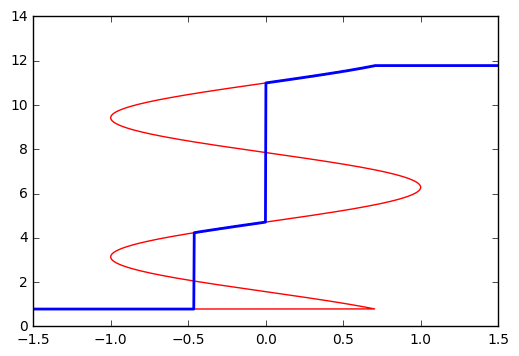

In [11]:
f_sin = lambda q: sin(q)

q_left = pi/4.
q_right = 15*pi/4.

xi, qxi, q_char, xi_char = osher_solution(f_sin, q_left, q_right, -1.5, 1.5)

plot(xi_char, q_char,'r')
plot(xi, qxi, 'b', linewidth=2)
ylim(0.,14.)

### Make an animation


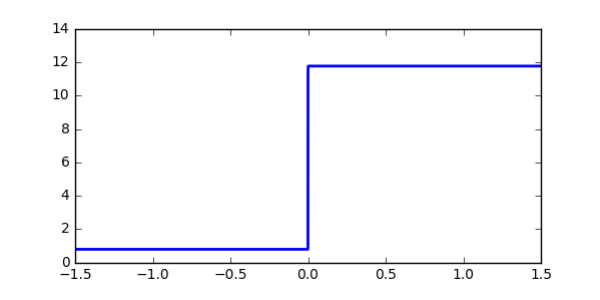
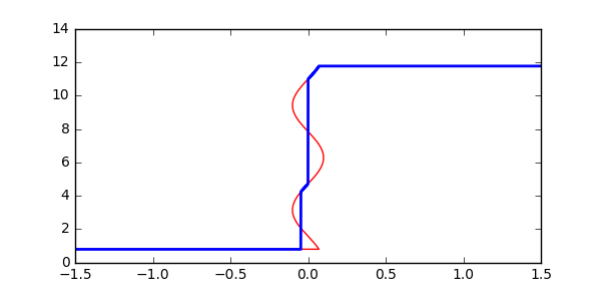
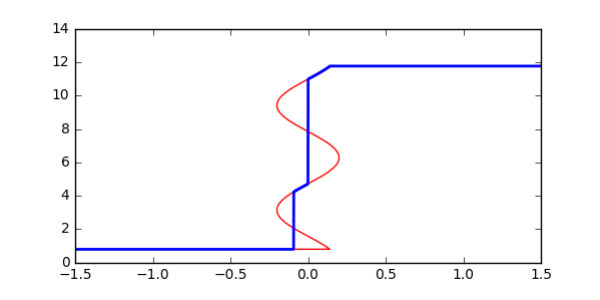
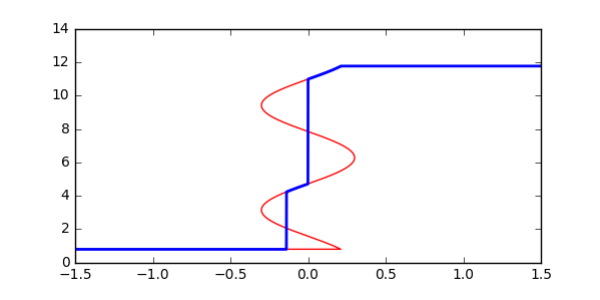
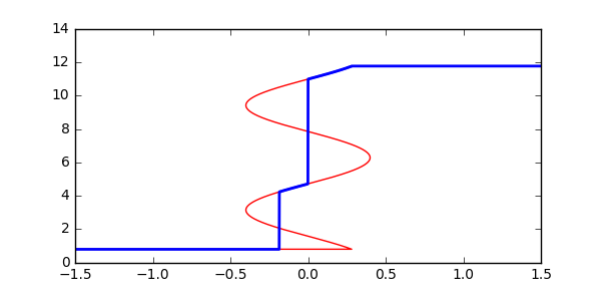
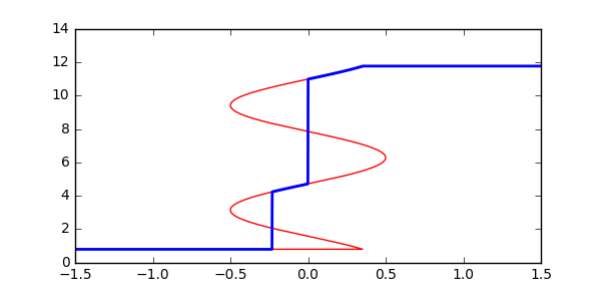
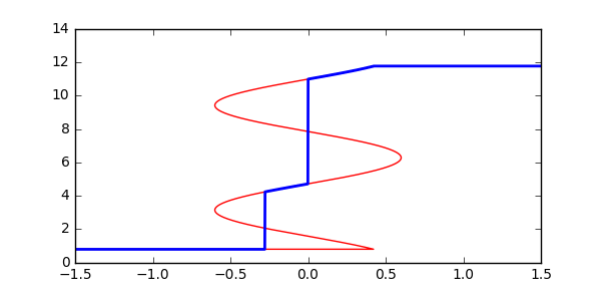
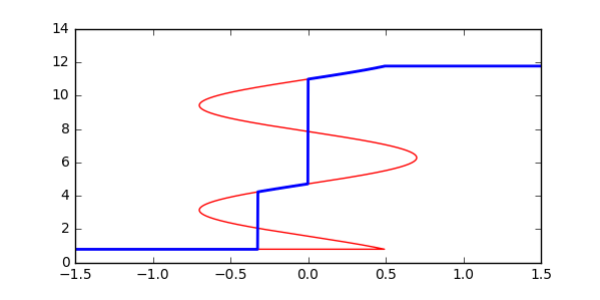
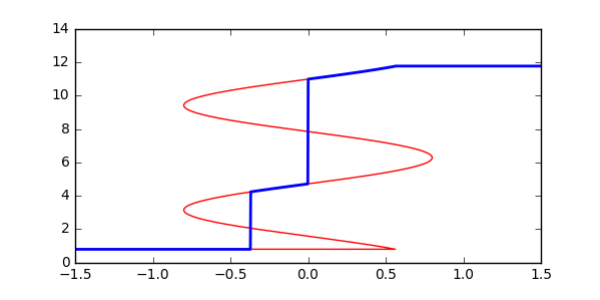
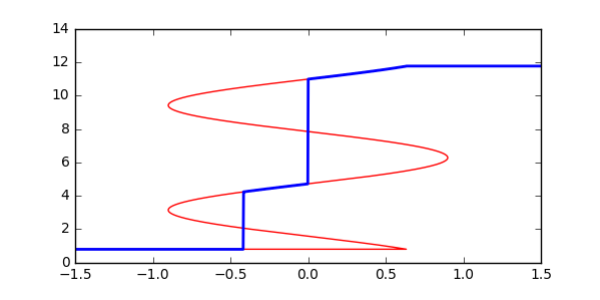
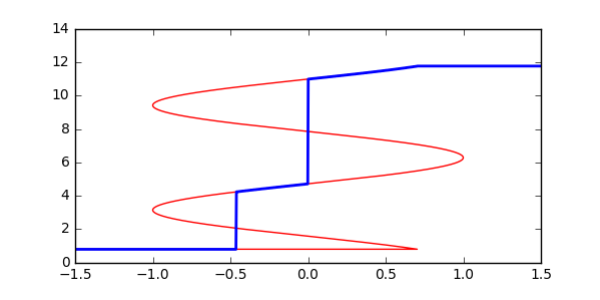

In [12]:
figs = []

# adjust first and last elements in xi arrays
# so things plot nicely for t \approx 0:

xi[0] *= 1e6; xi[-1] *= 1e6
xi_char[0] *= 1e6; xi_char[-1] *= 1e6

times = linspace(0,1,11)
times[0] = 1e-3  # adjust first time to be >0

for t in times:
    fig = figure(figsize=(6,3))
    plot(xi_char*t,q_char,'r')
    plot(xi*t, qxi, 'b', linewidth=2)
    xlim(-1.5, 1.5)
    ylim(0.,14.)
    figs.append(fig)
    close(fig)

anim = animation_tools.animate_figs(figs, style=animation_style, figsize=(6,3))
display(anim)

## Yet another example

(0, 25)

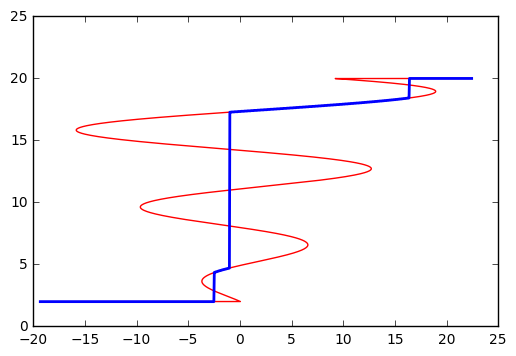

In [13]:
f = lambda q: q*sin(q)
q_left = 2.
q_right = 20.

xi, qxi, q_char, xi_char = osher_solution(f, q_left, q_right)

plot(xi_char,q_char,'r')
plot(xi, qxi, 'b', linewidth=2)
ylim(0,25)